In [1]:
# Load essential package
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb

# Setting random seed
np.random.seed(42)

print("Setup Complete")

Setup Complete


In [2]:
# Load data 
Train = pd.read_csv("train.csv")
Test = pd.read_csv("test.csv")

# We seperate the target from the test set to avoid unwanted result
X_test = Test.drop(columns = ["Transacted Price ($)"])
y_test = Test["Transacted Price ($)"]

print("Data Preparation Complete")

Data Preparation Complete


In [3]:
# Take a look at the data - 1
print("Training data")
Train.head(5)

Training data


,Project Name,Area (SQFT),Sale Date,Street Name,Type of Sale,Type of Area,Area (SQM),Property Type,Number of Units,Tenure,Postal District,Market Segment,Floor Level,Transacted Price ($)
0,THE AZURE,"1,733",Apr-21,OCEAN DRIVE,Resale,Strata,161,Condominium,1,99 yrs lease commencing from 2005,4,Core Central Region,01 to 05,2268888
1,FLORAVIEW,376.74,Jan-22,ANG MO KIO STREET 66,Resale,Strata,35,Apartment,1,Freehold,20,Outside Central Region,01 to 05,550000
2,LIVIA,914.94,May-24,PASIR RIS GROVE,Resale,Strata,85,Condominium,1,99 yrs lease commencing from 2008,18,Outside Central Region,16 to 20,1099000
3,FORETT@BUKIT TIMAH,721.19,Dec-23,TOH TUCK ROAD,Sub Sale,Strata,67.0,Apartment,1,Freehold,21,Rest of Central Region,01 to 05,1662000
4,NEWTON LODGE,"1,216.33",Jul-21,NEWTON ROAD,Resale,Strata,113,Apartment,1,Freehold,11,Core Central Region,01 to 05,1850000


In [4]:
# Just to make sure the test set look like training set
print("Test data")
X_test.head(5)

Test data


,Project Name,Area (SQFT),Sale Date,Street Name,Type of Sale,Type of Area,Area (SQM),Property Type,Number of Units,Tenure,Postal District,Market Segment,Floor Level
0,THE GAZANIA,904.18,Jan-22,HOW SUN DRIVE,New Sale,Strata,84,Condominium,1.0,Freehold,19.0,Outside Central Region,01 to 05
1,CANNINGHILL PIERS,441.32,Nov-21,CLARKE QUAY,New Sale,Strata,41,Apartment,1.0,99 yrs lease commencing from 2021,6.0,Rest of Central Region,16 to 20
2,PASIR RIS 8,775.01,Jul-21,PASIR RIS DRIVE 8,New Sale,Strata,72,Apartment,1.0,99 yrs lease commencing from 2021,18.0,Outside Central Region,06 to 10
3,MAYSPRINGS,"1,377.79",Sep-24,PETIR ROAD,Resale,Strata,128.0,Apartment,1.0,99 yrs lease commencing from 1994,23.0,Outside Central Region,06 to 10
4,BRADDELL VIEW,"1,700.71",Aug-24,BRADDELL HILL,Resale,Strata,158.0,Apartment,1.0,102 yrs lease commencing from 1978,20.0,Rest of Central Region,01 to 05


In [5]:
# Take a look at the data - 2
print(f"  Training data \n")
Train.info()
print(f"\n  Test data \n")
X_test.info()

  Training data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87268 entries, 0 to 87267
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Project Name          87268 non-null  object
 1   Area (SQFT)           87268 non-null  object
 2   Sale Date             87268 non-null  object
 3   Street Name           87268 non-null  object
 4   Type of Sale          87268 non-null  object
 5   Type of Area          87268 non-null  object
 6   Area (SQM)            87268 non-null  object
 7   Property Type         87268 non-null  object
 8   Number of Units       87268 non-null  int64 
 9   Tenure                87268 non-null  object
 10  Postal District       87268 non-null  int64 
 11  Market Segment        87268 non-null  object
 12  Floor Level           87268 non-null  object
 13  Transacted Price ($)  87268 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 9.3+ MB

  Test data 

<class 

In [6]:
# Two things to note
# 1. There are no missing values, at least not in null form
# 2. Area are not in numeric type, but it should be

# We handle the Area format right now
Train["Area (SQFT)"] = Train["Area (SQFT)"].str.replace(',', '').astype(float)
Train["Area (SQM)"] = Train["Area (SQM)"].str.replace(',', '').astype(float)

X_test["Area (SQFT)"] = X_test["Area (SQFT)"].str.replace(',', '').astype(float)
X_test["Area (SQM)"] = X_test["Area (SQM)"].str.replace(',', '').astype(float)

# Check
print(f"Trainind data")
print(Train["Area (SQFT)"].dtype)
print(Train["Area (SQM)"].dtype)

print(f"\nTest data")
print(X_test["Area (SQFT)"].dtype)
print(X_test["Area (SQM)"].dtype)

Trainind data
float64
float64

Test data
float64
float64


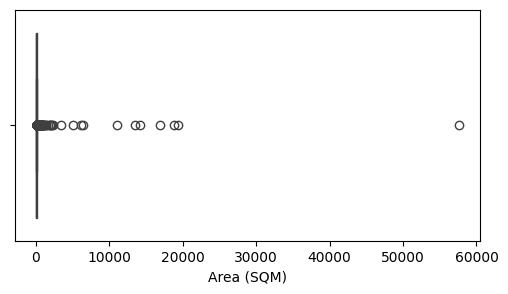

In [7]:
# Now we can begin to clean our training data
# We drop duplicate and check for outliers
Train = Train.drop_duplicates().reset_index(drop = True) # reset the index to keep the data tidy

# For outliers, we want to check Area and number of units 
# We first check Area using boxplot
plt.figure(figsize = (6,3))
sns.boxplot(x = Train["Area (SQM)"])

plt.show()

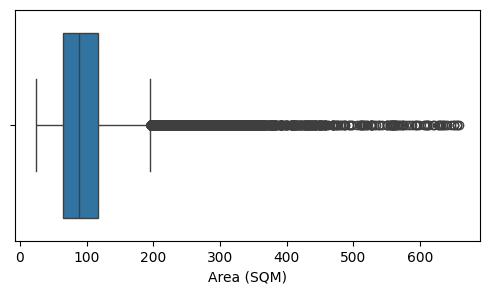

In [8]:
# To keep it concise, I remove the middle part of this process
# Just note that I originally proceed as 10000 -> 1000 -> 675 as the threshold to get rid of the outliers
# So now we remove those with SQM > 675 since there is a obvious gap seperates the outliers and the remaining data
Train = Train[Train["Area (SQM)"] < 675]

# We check again
plt.figure(figsize = (6,3))
sns.boxplot(x = Train["Area (SQM)"])

plt.show()

In [9]:
# For me, the rest of the outliers are too many to just remove them
# So I choose to keep them, and perhaps do some special handling afterwards
# Now we check number of units 

Unit_Q1 = Train["Number of Units"].quantile(0.25)
Unit_Q3 = Train["Number of Units"].quantile(0.75)
Unit_IQR = Unit_Q3 - Unit_Q1 

Unit_lower = Unit_Q1 - 1.5 * Unit_IQR
Unit_upper = Unit_Q3 + 1.5 * Unit_IQR

# Let's see how many are there
Outliers_Unit = Train[(Train["Number of Units"] > Unit_upper) | (Train["Number of Units"] < Unit_lower)]
len(Outliers_Unit)

20

In [10]:
# Since there are only 20, might as well just get rid of them
Train = Train.drop(Outliers_Unit.index)

# Now we try to deal with inconsistency
cat_cols_clean = ["Project Name", "Sale Date", "Street Name", 
                  "Type of Sale", "Type of Area", "Property Type", 
                  "Tenure", "Market Segment", "Floor Level"]

for col in cat_cols_clean:
    print(f"\n--- {col} ---")
    print(Train[col].unique())


--- Project Name ---
['THE AZURE' 'FLORAVIEW' 'LIVIA' ... 'KOVAN 81' 'DYNASTY LODGE'
 'CENTRO MANSIONS']

--- Sale Date ---
['Apr-21' 'Jan-22' 'May-24' 'Dec-23' 'Jul-21' 'Mar-21' 'Dec-21' 'Oct-21'
 'Apr-24' 'Nov-21' 'Aug-21' 'Feb-24' 'Sep-21' 'Aug-23' 'Dec-24' 'Jul-23'
 'Aug-20' 'Sep-24' 'Mar-23' 'Aug-22' 'Sep-22' 'Nov-20' 'Oct-22' 'Jan-21'
 'Oct-24' 'Sep-20' 'May-22' 'Nov-23' 'Nov-24' 'Jun-21' 'Nov-22' 'May-23'
 'Aug-24' 'Jun-22' 'Apr-23' 'Mar-24' 'Jul-22' 'Feb-23' 'Jun-24' 'May-21'
 'Jul-24' 'Jan-23' 'Sep-23' 'Apr-22' 'Dec-20' 'Oct-23' 'Mar-22' 'Dec-22'
 'Feb-21' 'Jun-23' 'Jan-24' 'Oct-20' 'Feb-22']

--- Street Name ---
['OCEAN DRIVE' 'ANG MO KIO STREET 66' 'PASIR RIS GROVE' 'TOH TUCK ROAD'
 'NEWTON ROAD' 'COVE DRIVE' 'LEEDON HEIGHTS' 'WALLICH STREET' 'PETIR ROAD'
 'CLARKE QUAY' 'SIGLAP ROAD' 'WEST COAST VALE' 'TAMARIND ROAD'
 "ST. MICHAEL'S ROAD" 'UPPER CHANGI ROAD EAST' 'PINE GROVE'
 'HOUGANG AVENUE 7' 'HILLVIEW RISE' 'ST. THOMAS WALK' 'YISHUN AVENUE 9'
 'AMBER GARDENS' 'BISHAN ST

In [11]:
# Something to note
# 1. Project Name has too many unique values, I choose to drop them later
# 2. Sale Date need to be transformed into year and month
# 3. Somehow Street Name doesn't contain as many unique values as Project Name, this implies that some have the same Street Name
#    I don't want to handle if the street name has typo, perhaps we can do it later depends on the performance
# 4. About Tenure, there are some inconsistencies in the format: yrs vs years, w/o from, freehold
#    I try to seperate them into beginning year and lease year
# 5. There is '-' in Floor Level, I don't know what that mean, might as well just leave as-is?

In [12]:
# Now we proceed to feature engineering

def feature_engineering_1(df):
    # To avoid touching the original data
    df = df.copy()

    # 1. Since we don't need both Area (SQFT) and Area (SQM) (they mean the same thing just in different form), I drop Area (SQFT)
    df = df.drop(columns = ["Area (SQFT)"])

    # 2. I also drop Project Name because it has too many unique values
    df = df.drop(columns = ["Project Name"])

    # 3. Since every observations are the same
    df = df.drop(columns = ["Number of Units"])

    # 4. We handle the sale date into numberical, and also drop the original 
    df["Sale Date"] = pd.to_datetime(df["Sale Date"], format = "%b-%y")
    df["Sale Year"] = df["Sale Date"].dt.year
    df["Sale Month"] = df["Sale Date"].dt.month
    df = df.drop(columns = ["Sale Date"])

    # 5. We handle Tenure, seperate them into lease period and beginning year
    def tenure_lease(x):
        x = str(x).lower().strip()
        
        if "freehold" in x: 
            return 999 # De facto in law
        elif "yrs" in x:
            return int(re.split(r"yrs", x)[0].strip())
        elif "years" in x:
            return int(re.split(r"years", x)[0].strip())
        else:
            return 0

    df["Lease"] = df["Tenure"].apply(tenure_lease)
    
    def tenure_begin(x):
        x = str(x).lower().strip()
        
        if "from" in x: 
            return int(re.split(r"from", x)[1].strip())
        else:
            return 1800 # Because the oldest value I see is around 1820, so I set to 1800 just to be clean

    df["Begin"] = df["Tenure"].apply(tenure_begin)

    df = df.drop(columns = ["Tenure"])

    # 6. We transform cols into categorical items so LightGBM can handle them
    cat_cols = ["Sale Month", "Street Name", "Type of Sale",
                "Type of Area", "Property Type",
                "Postal District", "Market Segment", "Floor Level"]

    for c in cat_cols:
        df[c] = df[c].astype('category')

    return df

Train_1 = feature_engineering_1(Train)
X_test_1 = feature_engineering_1(X_test)

print("Feature engineering complete")

# I also notice that for some year, the lease year is ridiculously high
# I cap this at 999, since freehold is 999
Train_1 = Train_1[Train_1["Lease"] <= 999]

print("Handle Complete")

# Prepare features and targets
X_train_1 = Train_1.drop(columns = ['Transacted Price ($)'])
y_train_1 = Train_1['Transacted Price ($)']

print("Drop Complete")

Feature engineering complete
Handle Complete
Drop Complete


In [13]:
# Initialize for LightGBM
model_1 = lgb.LGBMRegressor(random_state = 42, verbose = -1, n_jobs = -1)

# Prepare parameters grid
# Just for faster processing and I already repeat this code many many time
# I fix the max_depth, learning_rate and min_child_samples to -1, 0.1 and 5
params_1 = {"n_estimators": [300, 800],         
            "max_depth": [-1],              
            "learning_rate": [0.1],             
            "num_leaves": [31, 63],
            "feature_fraction": [0.8],
            "lambda_l2": [0, 1],
            "min_child_samples": [20, 50]}

grid_search_1 = GridSearchCV(model_1, 
                             params_1, 
                             cv = 5, 
                             scoring = 'neg_mean_squared_error',
                             n_jobs = -1,
                             verbose = 1,
                             error_score = "raise")

# Fit the grid search
grid_search_1.fit(X_train_1, y_train_1)

# Get the best model and parameters
best_model_1 = grid_search_1.best_estimator_
best_cv_rmse_1 = np.sqrt(-grid_search_1.best_score_)

# Test set predictions
y_pred_1 = best_model_1.predict(X_test_1)

print("Finish predicting")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Finish predicting


In [14]:
# Get score
test_rmse_1 = np.sqrt(mean_squared_error(y_test, y_pred_1))
test_r2_1 = r2_score(y_test, y_pred_1)
overfit_indicator_1 = abs(best_cv_rmse_1 - test_rmse_1)/test_rmse_1

# RMSE score
print(f"   CV RMSE: {best_cv_rmse_1:.4f}")
print(f"   Test RMSE: {test_rmse_1:.4f}")
print(f"   Test Set R²: {test_r2_1:.4f}")
print(f"\n   Performance Comparison:")
print(f"   CV vs Test difference: {abs(best_cv_rmse_1 - test_rmse_1):.4f}")
# I use 0.1 because it's easier to achieve but not too easy
print(f"   {'Good generalization' if overfit_indicator_1 < 0.1 else 'Check for overfitting'}") 

# Tracking perforamnce
print(f"\n   PERFORMANCE TRACKING - AFTER FEATURE ENGINEERING 1:")
print("   | Feature Engineering | Model Type |  Features  |     CV RMSE     |   Test RMSE   | Improvement |")
print("   |---------------------|------------|------------|-----------------|---------------|-------------|")
print(f"   |          1          |  LightGBM  |     {X_train_1.shape[1]}     |   {best_cv_rmse_1:.4f}   |  {test_rmse_1:.4f} |   Baseline  |")

# Get feature importance from the trained model
feature_importances_1 = best_model_1.feature_importances_

# Create importance dataframe
importance_df_1 = pd.DataFrame({'feature': X_train_1.columns,
                                'importance': feature_importances_1}).sort_values('importance', ascending = False)

print(f"\n   Features importance:")
for idx, row in importance_df_1.iterrows():
    print(f"   {row['feature']}: {row['importance']:.1f}")

   CV RMSE: 268837.6842
   Test RMSE: 1398721.7143
   Test Set R²: 0.5289

   Performance Comparison:
   CV vs Test difference: 1129884.0302
   Check for overfitting

   PERFORMANCE TRACKING - AFTER FEATURE ENGINEERING 1:
   | Feature Engineering | Model Type |  Features  |     CV RMSE     |   Test RMSE   | Improvement |
   |---------------------|------------|------------|-----------------|---------------|-------------|
   |          1          |  LightGBM  |     12     |   268837.6842   |  1398721.7143 |   Baseline  |

   Features importance:
   Area (SQM): 10386.0
   Street Name: 3882.0
   Sale Year: 2295.0
   Begin: 1672.0
   Sale Month: 1398.0
   Floor Level: 886.0
   Market Segment: 859.0
   Property Type: 808.0
   Postal District: 790.0
   Type of Sale: 602.0
   Lease: 422.0
   Type of Area: 0.0


In [13]:
# The RMSE is very bad, R2 also

# About the features performance, we can see that:
# 1. Type of Area has importance of 0, I don't know why, but I think it's OK to drop it
# 2. Sale_Month and Year works quite good, if we got time, we shall look into them to check if there are more to explore
# 3. I ask ChatGPT about this, because Street Name is so important, and my process is messy for categorizing, so the result is terrible.
#    I will handle this in second attempt by putting categorizing out of the function

def feature_engineering_2(df):

    df = df.copy()

    df = df.drop(columns = ["Area (SQFT)"])
    df = df.drop(columns = ["Project Name"])
    df = df.drop(columns = ["Number of Units"])

    # 1. Since Type of Area is not important, I just drop it
    df = df.drop(columns = ["Type of Area"])

    df["Sale Date"] = pd.to_datetime(df["Sale Date"], format = "%b-%y")
    df["Sale Year"] = df["Sale Date"].dt.year
    df["Sale Month"] = df["Sale Date"].dt.month
    df = df.drop(columns = ["Sale Date"])

    def tenure_lease(x):
        x = str(x).lower().strip()
        
        if "freehold" in x: 
            return 999 
        elif "yrs" in x:
            return int(re.split(r"yrs", x)[0].strip())
        elif "years" in x:
            return int(re.split(r"years", x)[0].strip())
        else:
            return 0

    df["Lease"] = df["Tenure"].apply(tenure_lease)
    
    def tenure_begin(x):
        x = str(x).lower().strip()
        
        if "from" in x: 
            return int(re.split(r"from", x)[1].strip())
        else:
            return 1800 

    df["Begin"] = df["Tenure"].apply(tenure_begin)

    df = df.drop(columns = ["Tenure"])

    # 2. For further transform, i have to transform them into string
    df["Sale Month"] = df["Sale Month"].astype(str)
    df["Postal District"] = df["Postal District"].astype(str)

    return df

def build_category_vocab(train_col: pd.Series, min_freq: int = 20):
    """
    From the TRAIN column, build a set of allowed categories.
    Anything less frequent than min_freq will be collapsed into 'OTHER'.
    """
    vc = train_col.value_counts()
    keep = vc[vc >= min_freq].index.tolist()
    # ensure deterministic order
    keep = sorted(keep)
    # append OTHER at the end
    keep.append("OTHER")
    return keep

def apply_category_vocab(df: pd.DataFrame, col: str, vocab: list):
    """
    Apply the TRAIN vocab to any df (train or test).
    Values not in vocab -> 'OTHER'.
    """
    df = df.copy()
    df.loc[~df[col].isin(vocab), col] = "OTHER"
    df[col] = pd.Categorical(df[col], categories = vocab)
    return df

# Call it 2 to fit with others
cat_cols_2 = ["Sale Month", "Street Name", "Type of Sale",
              "Property Type", "Postal District", 
              "Market Segment", "Floor Level"]

Train_2 = feature_engineering_2(Train)
X_test_2 = feature_engineering_2(X_test)

for c in cat_cols_2:
    n_unique = Train_2[c].nunique()
    min_freq = 1 if n_unique <= 10 else 20 # I check for street name that there're a lot of strret name appears more than 20 times
    vocab = build_category_vocab(Train_2[c], min_freq)
    Train_2 = apply_category_vocab(Train_2, c, vocab)
    X_test_2 = apply_category_vocab(X_test_2, c, vocab)

Train_2 = Train_2[Train_2["Lease"] <= 999]

# Prepare features and targets
X_train_2 = Train_2.drop(columns = ['Transacted Price ($)'])
y_train_2 = Train_2['Transacted Price ($)']

print("Feature engineering complete")

Feature engineering complete


In [16]:
model_2 = lgb.LGBMRegressor(random_state = 42, verbose = -1, n_jobs = -1)

params_2 = {"n_estimators": [300, 800],         
            "max_depth": [-1],              
            "learning_rate": [0.1],             
            "num_leaves": [31, 63],
            "feature_fraction": [0.8],
            "lambda_l2": [0, 1],
            "min_child_samples": [20, 50]}

grid_search_2 = GridSearchCV(model_2, 
                             params_2, 
                             cv = 5, 
                             scoring = 'neg_mean_squared_error',
                             n_jobs = -1,
                             verbose = 1,
                             error_score = "raise")

grid_search_2.fit(X_train_2, y_train_2)

best_model_2 = grid_search_2.best_estimator_
best_cv_rmse_2 = np.sqrt(-grid_search_2.best_score_)

y_pred_2 = best_model_2.predict(X_test_2)

print("Finish predicting")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Finish predicting


In [17]:
test_rmse_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))
test_r2_2 = r2_score(y_test, y_pred_2)
overfit_indicator_2 = abs(best_cv_rmse_2 - test_rmse_2)/test_rmse_2

print(f"   CV RMSE: {best_cv_rmse_2:.4f}")
print(f"   Test RMSE: {test_rmse_2:.4f}")
print(f"   Test Set R²: {test_r2_2:.4f}")
print(f"\n   Performance Comparison:")
print(f"   CV vs Test difference: {abs(best_cv_rmse_2 - test_rmse_2):.4f}")
print(f"   {'Good generalization' if overfit_indicator_2 < 0.1 else 'Check for overfitting'}")

# Tracking perforamnce
print(f"\n   PERFORMANCE TRACKING - AFTER FEATURE ENGINEERING 2:")
print("   | Feature Engineering | Model Type | Features |    CV  RMSE    |    Test  RMSE    | Improvement |")
print("   |---------------------|------------|----------|----------------|------------------|-------------|")
print(f"   |          1          |  LightGBM  |    {X_train_1.shape[1]}    |   {best_cv_rmse_1:.4f}  |   {test_rmse_1:.4f}   |   Baseline  |")
print(f"   |          2          |  LightGBM  |    {X_train_2.shape[1]}    |   {best_cv_rmse_2:.4f}  |   {test_rmse_2:.4f}   |    {((test_rmse_1 - test_rmse_2) / test_rmse_1 * 100):+.2f}%   |")

# Get feature importance from the trained model
feature_importances_2 = best_model_2.feature_importances_

# Create importance dataframe
importance_df_2 = pd.DataFrame({'feature': X_train_2.columns,
                                'importance': feature_importances_2}).sort_values('importance', ascending = False)

print(f"\n   Features importance:")
for idx, row in importance_df_2.iterrows():
    print(f"   {row['feature']}: {row['importance']:.1f}")

   CV RMSE: 274259.2674
   Test RMSE: 1341122.7729
   Test Set R²: 0.5669

   Performance Comparison:
   CV vs Test difference: 1066863.5055
   Check for overfitting

   PERFORMANCE TRACKING - AFTER FEATURE ENGINEERING 2:
   | Feature Engineering | Model Type | Features |    CV  RMSE    |    Test  RMSE    | Improvement |
   |---------------------|------------|----------|----------------|------------------|-------------|
   |          1          |  LightGBM  |    12    |   268837.6842  |   1398721.7143   |   Baseline  |
   |          2          |  LightGBM  |    11    |   274259.2674  |   1341122.7729   |    +4.12%   |

   Features importance:
   Area (SQM): 10310.0
   Street Name: 3852.0
   Sale Year: 2179.0
   Begin: 1810.0
   Sale Month: 1222.0
   Postal District: 948.0
   Market Segment: 915.0
   Floor Level: 875.0
   Property Type: 788.0
   Type of Sale: 615.0
   Lease: 486.0


In [14]:
# We can see that the test RMSE improve by 4%, not bad
# For next step I want to raise the repeat limit from 20 to 30
# I hope this can limit the importance of Street Name and make other features more relavant
# I also cap the lease year for test to 999 just like what I do for training set

def feature_engineering_3(df):
    
    df = df.copy()

    df = df.drop(columns = ["Area (SQFT)"])
    df = df.drop(columns = ["Project Name"])
    df = df.drop(columns = ["Number of Units"])
    df = df.drop(columns = ["Type of Area"])

    df["Sale Date"] = pd.to_datetime(df["Sale Date"], format = "%b-%y")
    df["Sale Year"] = df["Sale Date"].dt.year
    df["Sale Month"] = df["Sale Date"].dt.month
    df = df.drop(columns = ["Sale Date"])

    def tenure_lease(x):
        x = str(x).lower().strip()
        
        if "freehold" in x: 
            return 999 
        elif "yrs" in x:
            return int(re.split(r"yrs", x)[0].strip())
        elif "years" in x:
            return int(re.split(r"years", x)[0].strip())
        else:
            return 0

    df["Lease"] = df["Tenure"].apply(tenure_lease)
    
    def tenure_begin(x):
        x = str(x).lower().strip()
        
        if "from" in x: 
            return int(re.split(r"from", x)[1].strip())
        else:
            return 1800 

    df["Begin"] = df["Tenure"].apply(tenure_begin)

    df = df.drop(columns = ["Tenure"])

    df["Sale Month"] = df["Sale Month"].astype(str)
    df["Postal District"] = df["Postal District"].astype(str)

    return df

cat_cols_3 = ["Sale Month", "Street Name", "Type of Sale",
              "Property Type", "Postal District", 
              "Market Segment", "Floor Level"]

Train_3 = feature_engineering_3(Train)
X_test_3 = feature_engineering_3(X_test)

for c in cat_cols_3:
    n_unique = Train_3[c].nunique()
    min_freq = 1 if n_unique <= 20 else 30 # Here, I change to 30 
    vocab = build_category_vocab(Train_3[c], min_freq)
    Train_3 = apply_category_vocab(Train_3, c, vocab)
    X_test_3 = apply_category_vocab(X_test_3, c, vocab)

# I also tranform value in test set above 999 to just 999
Train_3 = Train_3[Train_3["Lease"] <= 999]
X_test_3["Lease"] = X_test_3["Lease"].clip(upper = 999)

# Prepare features and targets
X_train_3 = Train_3.drop(columns = ['Transacted Price ($)'])
y_train_3 = Train_3['Transacted Price ($)']

print("Feature engineering complete")

Feature engineering complete


In [19]:
model_3 = lgb.LGBMRegressor(random_state = 42, verbose = -1, n_jobs = -1)

params_3 = {"n_estimators": [300, 800],         
            "max_depth": [-1],              
            "learning_rate": [0.1],             
            "num_leaves": [31, 63],
            "feature_fraction": [0.8],
            "lambda_l2": [0, 1],
            "min_child_samples": [20, 50]}

grid_search_3 = GridSearchCV(model_3, 
                             params_3, 
                             cv = 5, 
                             scoring = 'neg_mean_squared_error',
                             n_jobs = -1,
                             verbose = 1,
                             error_score = "raise")

grid_search_3.fit(X_train_3, y_train_3)

best_model_3 = grid_search_3.best_estimator_
best_cv_rmse_3 = np.sqrt(-grid_search_3.best_score_)

y_pred_3 = best_model_3.predict(X_test_3)

print("Finish predicting")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Finish predicting


In [20]:
test_rmse_3 = np.sqrt(mean_squared_error(y_test, y_pred_3))
test_r2_3 = r2_score(y_test, y_pred_3)
overfit_indicator_3 = abs(best_cv_rmse_3 - test_rmse_3)/test_rmse_3

print(f"   CV RMSE: {best_cv_rmse_3:.4f}")
print(f"   Test RMSE: {test_rmse_3:.4f}")
print(f"   Test Set R²: {test_r2_3:.4f}")
print(f"\n   Performance Comparison:")
print(f"   CV vs Test difference: {abs(best_cv_rmse_3 - test_rmse_3):.4f}")
print(f"   {'Good generalization' if overfit_indicator_3 < 0.1 else 'Check for overfitting'}")

# Tracking perforamnce
print(f"\n   PERFORMANCE TRACKING - AFTER FEATURE ENGINEERING 3:")
print("   | Feature Engineering | Model Type | Features |    CV  RMSE    |    Test  RMSE    | Improvement |")
print("   |---------------------|------------|----------|----------------|------------------|-------------|")
print(f"   |          1          |  LightGBM  |    {X_train_1.shape[1]}    |   {best_cv_rmse_1:.4f}  |   {test_rmse_1:.4f}   |   Baseline  |")
print(f"   |          2          |  LightGBM  |    {X_train_2.shape[1]}    |   {best_cv_rmse_2:.4f}  |   {test_rmse_2:.4f}   |    {((test_rmse_1 - test_rmse_2) / test_rmse_1 * 100):+.2f}%   |")
print(f"   |          3          |  LightGBM  |    {X_train_3.shape[1]}    |   {best_cv_rmse_3:.4f}  |   {test_rmse_3:.4f}   |    {((test_rmse_2 - test_rmse_3) / test_rmse_2 * 100):+.2f}%   |")

# Get feature importance from the trained model
feature_importances_3 = best_model_3.feature_importances_

# Create importance dataframe
importance_df_3 = pd.DataFrame({'feature': X_train_3.columns,
                                'importance': feature_importances_3}).sort_values('importance', ascending = False)

print(f"\n   Features importance:")
for idx, row in importance_df_3.iterrows():
    print(f"   {row['feature']}: {row['importance']:.1f}")

   CV RMSE: 291387.9624
   Test RMSE: 1288027.5549
   Test Set R²: 0.6005

   Performance Comparison:
   CV vs Test difference: 996639.5925
   Check for overfitting

   PERFORMANCE TRACKING - AFTER FEATURE ENGINEERING 3:
   | Feature Engineering | Model Type | Features |    CV  RMSE    |    Test  RMSE    | Improvement |
   |---------------------|------------|----------|----------------|------------------|-------------|
   |          1          |  LightGBM  |    12    |   268837.6842  |   1398721.7143   |   Baseline  |
   |          2          |  LightGBM  |    11    |   274259.2674  |   1341122.7729   |    +4.12%   |
   |          3          |  LightGBM  |    11    |   291387.9624  |   1288027.5549   |    +3.96%   |

   Features importance:
   Area (SQM): 10377.0
   Street Name: 3698.0
   Sale Year: 2143.0
   Begin: 2002.0
   Sale Month: 1244.0
   Postal District: 951.0
   Market Segment: 937.0
   Floor Level: 877.0
   Property Type: 738.0
   Type of Sale: 568.0
   Lease: 465.0


In [15]:
# The performance improve by another 4%, nice
# And I just recall that, even though I remove Number of Units from the model
# But that's only because my training model all have units of 1, for test set might not be the case
# I think the best approach here will be to replace area by area/units, and keep Number of Units for reference 
# In this case, I choose to work from the very begining 
Train_retry = pd.read_csv("train.csv")

# I just skip explaining and keep going on
Train_retry["Area (SQFT)"] = Train_retry["Area (SQFT)"].str.replace(',', '').astype(float)
Train_retry["Area (SQM)"] = Train_retry["Area (SQM)"].str.replace(',', '').astype(float)
Train_retry = Train_retry.drop_duplicates().reset_index(drop = True)
# We still trim the data a little bit, choose 10000 this time so the model can still learn from high unit counts
Train_retry = Train_retry[Train_retry["Area (SQM)"] < 10000]

print("Handle Complete")

def feature_engineering_4(df):
    
    df = df.copy()

    # Add Area/Unit, we use SQM for no special reason
    df["APU"] = df["Area (SQM)"] / df["Number of Units"]

    # We use the new APU, so drop the old one 
    df = df.drop(columns = ["Area (SQFT)"])
    df = df.drop(columns = ["Area (SQM)"]) 
    # We don't drop Number of Units this time 
    df = df.drop(columns = ["Project Name"])
    df = df.drop(columns = ["Type of Area"])

    df["Sale Date"] = pd.to_datetime(df["Sale Date"], format = "%b-%y")
    df["Sale Year"] = df["Sale Date"].dt.year
    df["Sale Month"] = df["Sale Date"].dt.month
    df = df.drop(columns = ["Sale Date"])

    def tenure_lease(x):
        x = str(x).lower().strip()
        
        if "freehold" in x: 
            return 999 
        elif "yrs" in x:
            return int(re.split(r"yrs", x)[0].strip())
        elif "years" in x:
            return int(re.split(r"years", x)[0].strip())
        else:
            return 0

    df["Lease"] = df["Tenure"].apply(tenure_lease)
    
    def tenure_begin(x):
        x = str(x).lower().strip()
        
        if "from" in x: 
            return int(re.split(r"from", x)[1].strip())
        else:
            return 1800 

    df["Begin"] = df["Tenure"].apply(tenure_begin)

    df = df.drop(columns = ["Tenure"])

    df["Sale Month"] = df["Sale Month"].astype(str)
    df["Postal District"] = df["Postal District"].astype(str)

    return df

cat_cols_4 = ["Sale Month", "Street Name", "Type of Sale",
              "Property Type", "Postal District", 
              "Market Segment", "Floor Level"]

Train_4 = feature_engineering_4(Train_retry)
X_test_4 = feature_engineering_4(X_test)

for c in cat_cols_4:
    n_unique = Train_4[c].nunique()
    min_freq = 1 if n_unique <= 20 else 30 
    vocab = build_category_vocab(Train_4[c], min_freq)
    Train_4 = apply_category_vocab(Train_4, c, vocab)
    X_test_4 = apply_category_vocab(X_test_4, c, vocab)

Train_4 = Train_4[Train_4["Lease"] <= 999]
X_test_4["Lease"] = X_test_4["Lease"].clip(upper = 999)

X_train_4 = Train_4.drop(columns = ['Transacted Price ($)'])
y_train_4 = Train_4['Transacted Price ($)']

print("Feature engineering complete")

Handle Complete
Feature engineering complete


In [16]:
model_4 = lgb.LGBMRegressor(random_state = 42, verbose = -1, n_jobs = -1)

params_4 = {"n_estimators": [300, 800],         
            "max_depth": [-1],              
            "learning_rate": [0.1],             
            "num_leaves": [31, 63],
            "feature_fraction": [0.8],
            "lambda_l2": [0, 1],
            "min_child_samples": [20, 50]}

grid_search_4 = GridSearchCV(model_4, 
                             params_4, 
                             cv = 5, 
                             scoring = 'neg_mean_squared_error',
                             n_jobs = -1,
                             verbose = 1,
                             error_score = "raise")

grid_search_4.fit(X_train_4, y_train_4)

best_model_4 = grid_search_4.best_estimator_
best_cv_rmse_4 = np.sqrt(-grid_search_4.best_score_)

y_pred_4 = best_model_4.predict(X_test_4)

print("Finish predicting")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Finish predicting


In [23]:
test_rmse_4 = np.sqrt(mean_squared_error(y_test, y_pred_4))
test_r2_4 = r2_score(y_test, y_pred_4)
overfit_indicator_4 = abs(best_cv_rmse_4 - test_rmse_4)/test_rmse_4

print(f"   CV RMSE: {best_cv_rmse_4:.4f}")
print(f"   Test RMSE: {test_rmse_4:.4f}")
print(f"   Test Set R²: {test_r2_4:.4f}")
print(f"\n   Performance Comparison:")
print(f"   CV vs Test difference: {abs(best_cv_rmse_4 - test_rmse_4):.4f}")
print(f"   {'Good generalization' if overfit_indicator_4 < 0.1 else 'Check for overfitting'}")

# Tracking perforamnce
print(f"\n   PERFORMANCE TRACKING - AFTER FEATURE ENGINEERING 4:")
print("   | Feature Engineering | Model Type | Features |     CV RMSE     |    Test  RMSE    |  Improvement |")
print("   |---------------------|------------|----------|-----------------|------------------|--------------|")
print(f"   |          1          |  LightGBM  |    {X_train_1.shape[1]}    |   {best_cv_rmse_1:.4f}   |   {test_rmse_1:.4f}   |   Baseline   |")
print(f"   |          2          |  LightGBM  |    {X_train_2.shape[1]}    |   {best_cv_rmse_2:.4f}   |   {test_rmse_2:.4f}   |    {((test_rmse_1 - test_rmse_2) / test_rmse_1 * 100):+.2f}%    |")
print(f"   |          3          |  LightGBM  |    {X_train_3.shape[1]}    |   {best_cv_rmse_3:.4f}   |   {test_rmse_3:.4f}   |    {((test_rmse_2 - test_rmse_3) / test_rmse_2 * 100):+.2f}%    |")
print(f"   |          4          |  LightGBM  |    {X_train_4.shape[1]}    |   {best_cv_rmse_4:.4f}  |   {test_rmse_4:.4f}   |    {((test_rmse_3 - test_rmse_4) / test_rmse_3 * 100):+.2f}%   |")

# Get feature importance from the trained model
feature_importances_4 = best_model_4.feature_importances_

# Create importance dataframe
importance_df_4 = pd.DataFrame({'feature': X_train_4.columns,
                                'importance': feature_importances_4}).sort_values('importance', ascending = False)

print(f"\n   Features importance:")
for idx, row in importance_df_4.iterrows():
    print(f"   {row['feature']}: {row['importance']:.1f}")

   CV RMSE: 1137984.2171
   Test RMSE: 1053614.7474
   Test Set R²: 0.7327

   Performance Comparison:
   CV vs Test difference: 84369.4698
   Good generalization

   PERFORMANCE TRACKING - AFTER FEATURE ENGINEERING 4:
   | Feature Engineering | Model Type | Features |     CV RMSE     |    Test  RMSE    |  Improvement |
   |---------------------|------------|----------|-----------------|------------------|--------------|
   |          1          |  LightGBM  |    12    |   268837.6842   |   1398721.7143   |   Baseline   |
   |          2          |  LightGBM  |    11    |   274259.2674   |   1341122.7729   |    +4.12%    |
   |          3          |  LightGBM  |    11    |   291387.9624   |   1288027.5549   |    +3.96%    |
   |          4          |  LightGBM  |    12    |   1137984.2171  |   1053614.7474   |    +18.20%   |

   Features importance:
   APU: 7662.0
   Street Name: 2724.0
   Sale Year: 1929.0
   Sale Month: 1168.0
   Begin: 1166.0
   Market Segment: 840.0
   Floor Level:

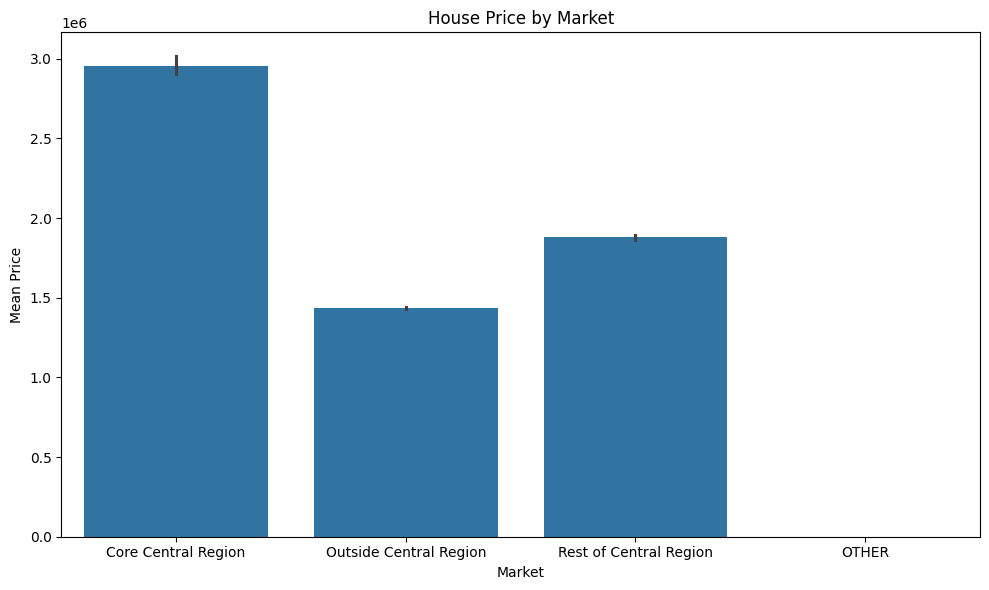

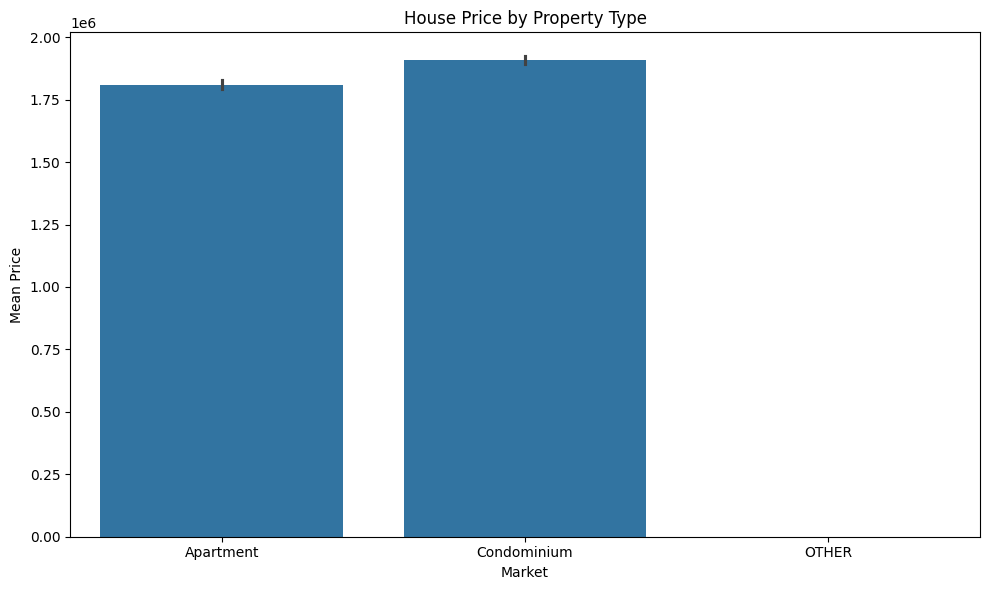

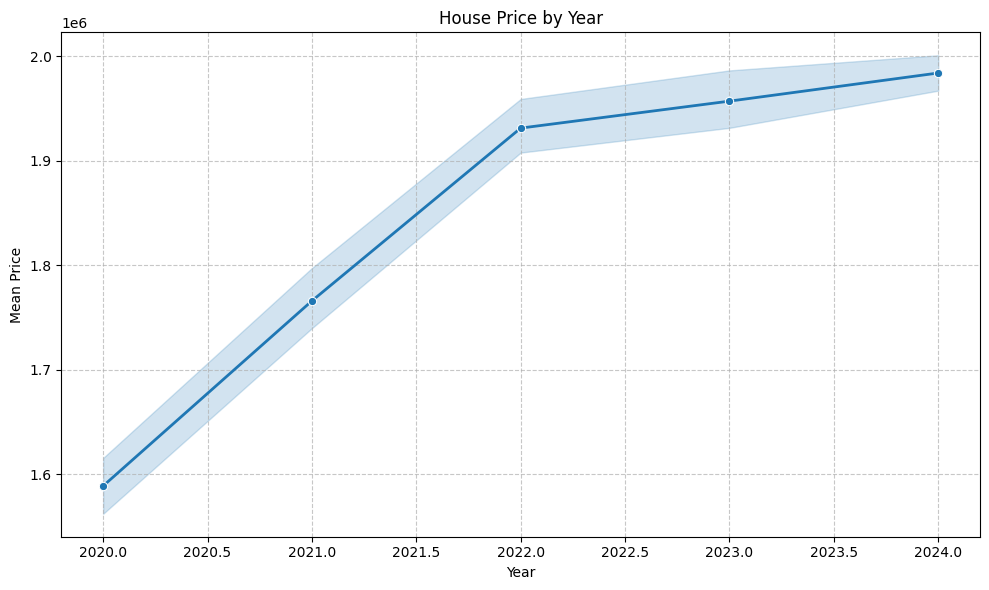

In [24]:
# Though the test RMSE improve massively, the CV RMSE also increased ridiclously, even over the Test RMSE
# But looking at bright side, this is the first time I achieve good generalization
# The Number of Units is least important, shows that the linear relation is not present here
# I guess I should stop here and start explaning the features.

# 1. Trend in location 

plt.figure(figsize = (10,6))
sns.barplot(x = "Market Segment", y = "Transacted Price ($)", data = Train_4, estimator = 'mean')
plt.title('House Price by Market')
plt.xlabel('Market')
plt.ylabel('Mean Price')
plt.tight_layout()
plt.show()

# 2. Trend in property type

plt.figure(figsize = (10,6))
sns.barplot(x = "Property Type", y = "Transacted Price ($)", data = Train_4, estimator = 'mean')
plt.title('House Price by Property Type')
plt.xlabel('Market')
plt.ylabel('Mean Price')
plt.tight_layout()
plt.show()

# 3. Trend in time

# Plot the line chart
plt.figure(figsize = (10,6))
sns.lineplot(x = 'Sale Year', 
             y = 'Transacted Price ($)', 
             data = Train_4, 
             marker = 'o', 
             linewidth = 2)

plt.title('House Price by Year')
plt.xlabel('Year')
plt.ylabel('Mean Price')
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.tight_layout()
plt.show()

/var/folders/l9/4r_rp7vn5c71ky_mwkqplhgh0000gn/T/ipykernel_5129/4129023787.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_4, plot_type = "bar")


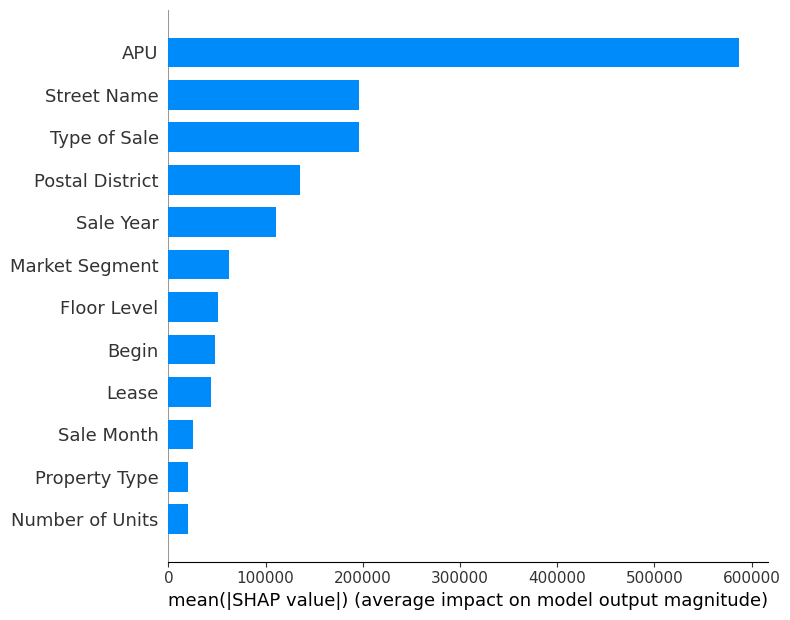

/var/folders/l9/4r_rp7vn5c71ky_mwkqplhgh0000gn/T/ipykernel_5129/4129023787.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_4)


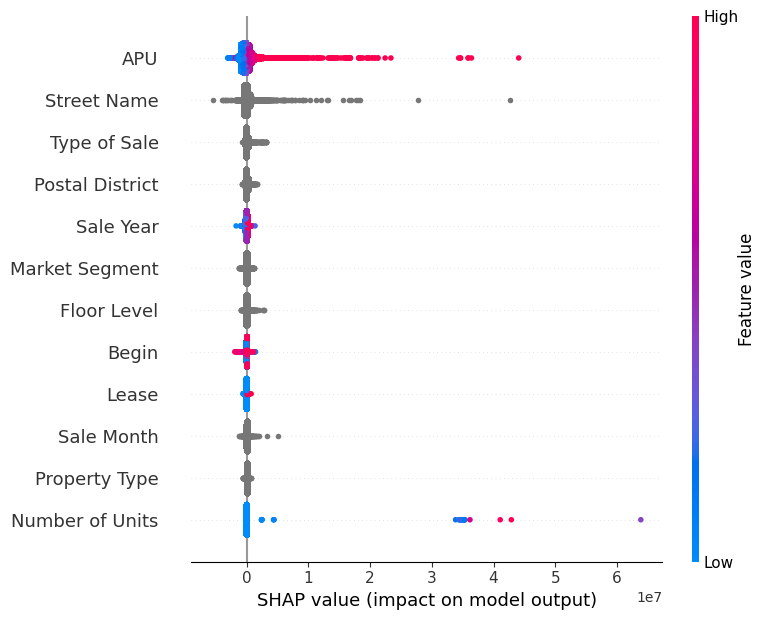

In [17]:
import shap

# 假設你已有訓練好的模型名稱為 model_4，訓練資料為 X_train_4, y_train_4
explainer = shap.TreeExplainer(best_model_4)
shap_values = explainer.shap_values(X_train_4)

# 1️⃣ 全域重要度總覽
shap.summary_plot(shap_values, X_train_4, plot_type = "bar")

# 2️⃣ 詳細散點圖（可觀察非線性）
shap.summary_plot(shap_values, X_train_4)

# 3️⃣ 若想針對單一樣本解釋（例如某筆高價公寓）
# sample_idx = 10  # 改成你想看的樣本 index
# shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X_train_4.iloc[sample_idx,:])